# Compact polarization splitter-rotator

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FPolarizationSplitterRotator.ipynb).

Silicon-on-insulator (SOI) devices are known to be polarization sensitive. Devices that can manipulate the polarization of light are important components of an integrated photonic system. 

This model demonstrates the design of a compact polarization splitter-rotator that consists of an adiabatic waveguide tapper and an asymmetric directional coupler. When the TM0 mode is launched at the input end, it is efficiently converted into the TE1 mode at the tapper and then coupled to the TE0 mode at the narrow waveguide through the directional coupler. When the TE0 mode is launched at the input end, it propagates through the tapper without polarization change and coupling to the narrow waveguide. That is, the TE and TM polarizations are separated by this device and the output is always TE polarization, as schematically shown below. This model is based on [Daoxin Dai and John E. Bowers, "Novel concept for ultracompact polarization splitter-rotator based on silicon nanowires," Opt. Express 19, 10940-10949 (2011)](https://opg.optica.org/oe/fulltext.cfm?uri=oe-19-11-10940&id=214189).

<img src="img/polarizer_rotator.png">

## Simulation Setup 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins import ModeSolver


[19:55:59] INFO     Using client version: 1.8.1                                                     ]8;id=78109;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\__init__.py\__init__.py]8;;\:]8;id=934316;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\__init__.py#112\112]8;;\

Define geometric parameters. The device consists of a wide tapered waveguide and a narrow waveguide. They are coupled through a directional coupler.

In [2]:
w0 = 0.54  # width of the input/output single mode waveguides
w1 = 0.69  # width of the first tapper
w2 = 0.83  # width of the second tapper
w3 = 0.9  # width of the third tapper
w4 = 0.405  # width of the narrow waveguide
w_gap = 0.15  # gap of the directional coupler
L_tp1 = 4  # length of the first tapper
L_tp2 = 44  # length of the second tapper
L_tp3 = L_tp1 * (w3 - w2) / (w1 - w0)  # length of the third tapper
L_dc = 7  # length of the directional coupler
L_tpout = 14  # length of the output tapper
shift = 0.4  # shift of the narrow waveguide output
h_co = 0.22  # thickness of the waveguides
inf_eff = 1000  # effective infinity used to make sure the waveguides extend into pml


Define materials. The waveguides are made of silicon. The upper cladding is silicon nitride and the lower cladding is silicon oxide.

In [3]:
si = td.Medium(permittivity=3.455**2)
sio2 = td.Medium(permittivity=1.445**2)
si3n4 = td.Medium(permittivity=2**2)


The silicon structures are defined using PolySlabs. The coordinates of the vertices can be determined by the taper widths and lengths.

In [4]:
cladding = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -h_co / 2), rmax=(inf_eff, inf_eff, inf_eff)
    ),
    medium=si3n4,
)

vertices = np.array(
    [
        (-w0 / 2, -inf_eff),
        (-w0 / 2, 0),
        (-w1 / 2, L_tp1),
        (-w2 / 2, L_tp1 + L_tp2),
        (-w3 / 2, L_tp1 + L_tp2 + L_tp3),
        (-w3 / 2, L_tp1 + L_tp2 + L_tp3 + L_dc),
        (-w0 / 2, L_tp1 + L_tp2 + L_tp3 + L_dc + L_tpout),
        (-w0 / 2, inf_eff),
        (w0 / 2, inf_eff),
        (w0 / 2, L_tp1 + L_tp2 + L_tp3 + L_dc + L_tpout),
        (w3 / 2, L_tp1 + L_tp2 + L_tp3 + L_dc),
        (w3 / 2, L_tp1 + L_tp2 + L_tp3),
        (w2 / 2, L_tp1 + L_tp2),
        (w1 / 2, L_tp1),
        (w0 / 2, 0),
        (w0 / 2, -inf_eff),
    ]
)

wide_wg = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-h_co / 2, h_co / 2)),
    medium=si,
)

vertices = np.array(
    [
        (-w3 / 2 - w_gap - w4, L_tp1 + L_tp2 + L_tp3),
        (-w3 / 2 - w_gap - w4, L_tp1 + L_tp2 + L_tp3 + L_dc),
        (-w3 / 2 - w_gap - w4 - shift, L_tp1 + L_tp2 + L_tp3 + L_dc + L_tpout),
        (-w3 / 2 - w_gap - w4 - shift, inf_eff),
        (-w3 / 2 - w_gap - shift, inf_eff),
        (-w3 / 2 - w_gap - shift, L_tp1 + L_tp2 + L_tp3 + L_dc + L_tpout),
        (-w3 / 2 - w_gap, L_tp1 + L_tp2 + L_tp3 + L_dc),
        (-w3 / 2 - w_gap, L_tp1 + L_tp2 + L_tp3),
    ]
)
narrow_wg = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(-h_co / 2, h_co / 2)),
    medium=si,
)


Set up a mode source for excitation. First, we launch the TE0 mode with the mode source. Later, we will change the mode source to launch the TM0 mode. 

Two flux monitors and two mode monitors are set up at the outputs of the wide and narrow waveguides. A field monitor is added to monitor the field at z=0 plane. 

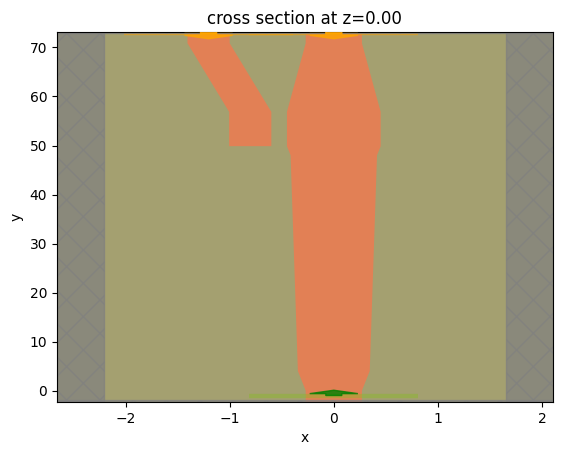

In [5]:
lda0 = 1.525  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.45, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range

# buffer lengths in x and y directions
buffer_x = 1
buffer_y = 2

# simulation domain size
Lx = w3 + w_gap + w4 + shift + 2 * buffer_x
Ly = L_tp1 + L_tp2 + L_tp3 + L_dc + L_tpout + 2 * buffer_y
Lz = 10 * h_co
sim_size = (Lx, Ly, Lz)

# define mode source that launches the TE0 mode (mode_index=0). Later, we will modify it to investigate the TM0 mode case
mode_spec = td.ModeSpec(num_modes=2, target_neff=3)
mode_source = td.ModeSource(
    center=(0, -buffer_y / 2, 0),
    size=(3 * w0, 0, 5 * h_co),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# define a field monitor
field_monitor = td.FieldMonitor(
    center=(0, -buffer_y / 2, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

# define two flux monitors at the two outputs to measure transmission
flux_monitor1 = td.FluxMonitor(
    center=(0, Ly - buffer_y, 0), size=(3 * w0, 0, 5 * h_co), freqs=freqs, name="flux1"
)

flux_monitor2 = td.FluxMonitor(
    center=(-w4 / 2 - w3 / 2 - w_gap - shift, Ly - buffer_y, 0),
    size=(3 * w0, 0, 5 * h_co),
    freqs=freqs,
    name="flux2",
)

# define two mode monitors at the two outputs to study output polarization
mode_monitor1 = td.ModeMonitor(
    center=(0, Ly - buffer_y, 0),
    size=(3 * w0, 0, 5 * h_co),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode1",
)

mode_monitor2 = td.ModeMonitor(
    center=(-w4 / 2 - w3 / 2 - w_gap - shift, Ly - buffer_y, 0),
    size=(3 * w0, 0, 5 * h_co),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode2",
)

# initialize the Simulation object
sim = td.Simulation(
    center=(-(shift + w_gap) / 2, Ly / 2 - buffer_y, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=[cladding, wide_wg, narrow_wg],
    sources=[mode_source],
    monitors=[
        field_monitor,
        flux_monitor1,
        flux_monitor2,
        mode_monitor1,
        mode_monitor2,
    ],
    run_time=2e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
)

# plot the simulation at z=0 to inspect the structure, source, and monitors
fig = plt.figure()
ax = fig.add_subplot(111)
sim.plot(z=0, ax=ax)
ax.set_aspect("auto")


Before the simulation, we can visualize the mode fields to ensure we are launching the correct mode at the source.

In [6]:
mode_solver = ModeSolver(
    simulation=sim,
    plane=td.Box(center=(0, -buffer_y / 2, 0), size=(2 * w0, 0, 5 * h_co)),
    mode_spec=mode_spec,
    freqs=[freq0],
)
mode_data = mode_solver.solve()


As expected, the first mode (mode_index=0) is the TE0 mode.

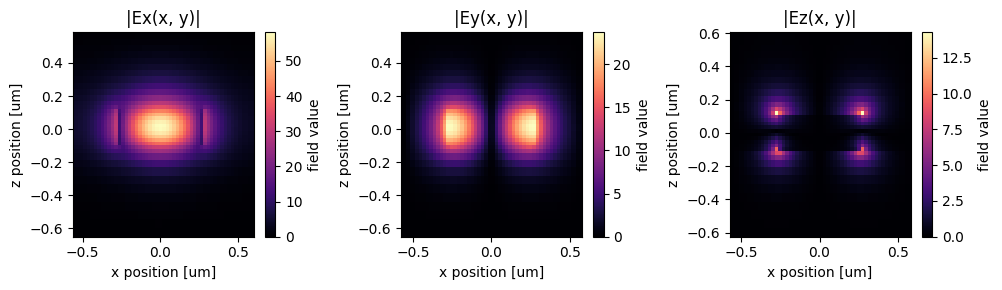

In [7]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
abs(mode_data.Ex.isel(mode_index=0)).plot(x="x", y="z", ax=ax1, cmap="magma")
abs(mode_data.Ey.isel(mode_index=0)).plot(x="x", y="z", ax=ax2, cmap="magma")
abs(mode_data.Ez.isel(mode_index=0)).plot(x="x", y="z", ax=ax3, cmap="magma")

ax1.set_title("|Ex(x, y)|")
ax2.set_title("|Ey(x, y)|")
ax3.set_title("|Ez(x, y)|")
plt.show()


The second mode (mode_index=1) is the TM0 mode.

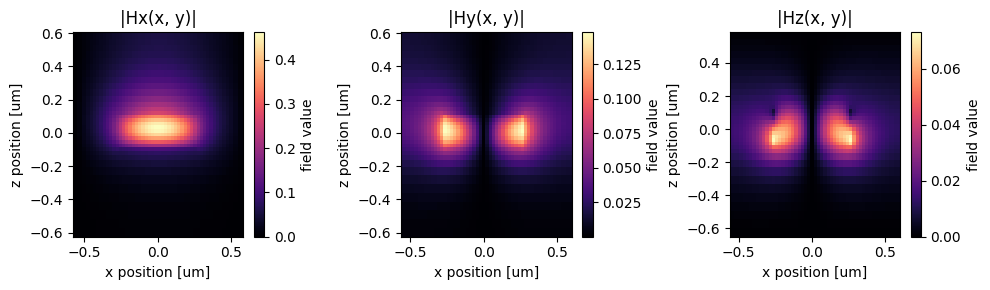

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
abs(mode_data.Hx.isel(mode_index=1)).plot(x="x", y="z", ax=ax1, cmap="magma")
abs(mode_data.Hy.isel(mode_index=1)).plot(x="x", y="z", ax=ax2, cmap="magma")
abs(mode_data.Hz.isel(mode_index=1)).plot(x="x", y="z", ax=ax3, cmap="magma")

ax1.set_title("|Hx(x, y)|")
ax2.set_title("|Hy(x, y)|")
ax3.set_title("|Hz(x, y)|")
plt.show()


After making sure the simulation setups and mode profiles are correct, submit the simulation to the server.

In [9]:
job = web.Job(simulation=sim, task_name="polarization_splitter_rotator")
sim_data = job.run(path="data/simulation_data.hdf5")


[19:56:02] INFO     Using Tidy3D credentials from stored file.                                           ]8;id=348306;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\auth.py\auth.py]8;;\:]8;id=223458;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\auth.py#70\70]8;;\

[19:56:03] INFO     Authentication successful.                                                           ]8;id=427876;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\auth.py\auth.py]8;;\:]8;id=979431;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\auth.py#30\30]8;;\

[19:56:04] INFO     Created task 'polarization_splitter_rotator' with task_id                         ]8;id=296420;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=540306;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#120\120]8;;\
                    '7d62d5d8-8ab5-4251-ad04-04e43fde0a05'.                                                        

Output()

[19:56:05] INFO     Maximum FlexUnit cost: 0.692                                                      ]8;id=501717;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=156246;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#252\252]8;;\

           INFO     status = queued                                                                   ]8;id=482879;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=745576;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#261\261]8;;\

Output()

[19:56:09] INFO     status = preprocess                                                               ]8;id=336478;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=389533;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#273\273]8;;\

[19:56:18] INFO     starting up solver                                                                ]8;id=598324;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=392303;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#277\277]8;;\

[19:56:28] INFO     running solver                                                                    ]8;id=553266;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=302850;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#283\283]8;;\

Output()

[19:57:03] INFO     early shutoff detected, exiting.                                                  ]8;id=569433;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=567671;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#294\294]8;;\

           INFO     status = postprocess                                                              ]8;id=597532;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=743239;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#300\300]8;;\

Output()

[19:57:10] INFO     status = success                                                                  ]8;id=74692;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=18222;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#306\306]8;;\

           INFO     Billed FlexUnit cost: 0.361                                                       ]8;id=101053;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=647830;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#310\310]8;;\

[19:57:11] INFO     downloading file "output/monitor_data.hdf5" to "data/simulation_data.hdf5"        ]8;id=833179;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=805432;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#592\592]8;;\

Output()

[19:57:13] INFO     loading SimulationData from data/simulation_data.hdf5                             ]8;id=894655;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=840179;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#414\414]8;;\

## Case 1: Launching the TE0 Mode at the Input

Visualize the field intensity distribution to see the propagation of the input TE0 mode. We can see that it propagates through the wide waveguide with no coupling to the narrow waveguide. 

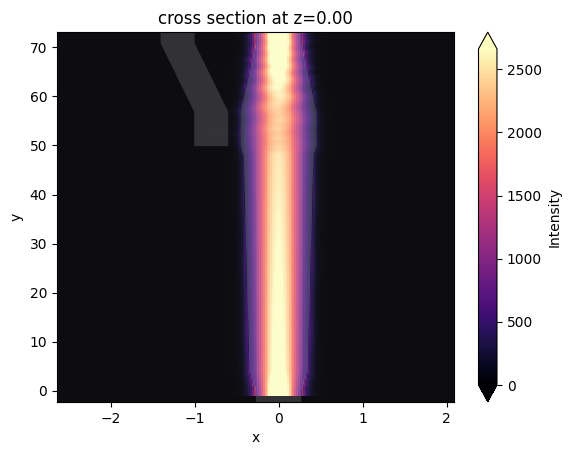

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
sim_data.plot_field("field", "int", ax=ax, f=freq0)
ax.set_aspect("auto")


Plot the transmission at the two outputs. The transmission through the wide waveguide is nearly 100% with very little coupling to the narrow waveguide. 

Then plot the mode composition at the wide waveguide output. We can see that the TE polarization is preserved with no conversion to TM. 

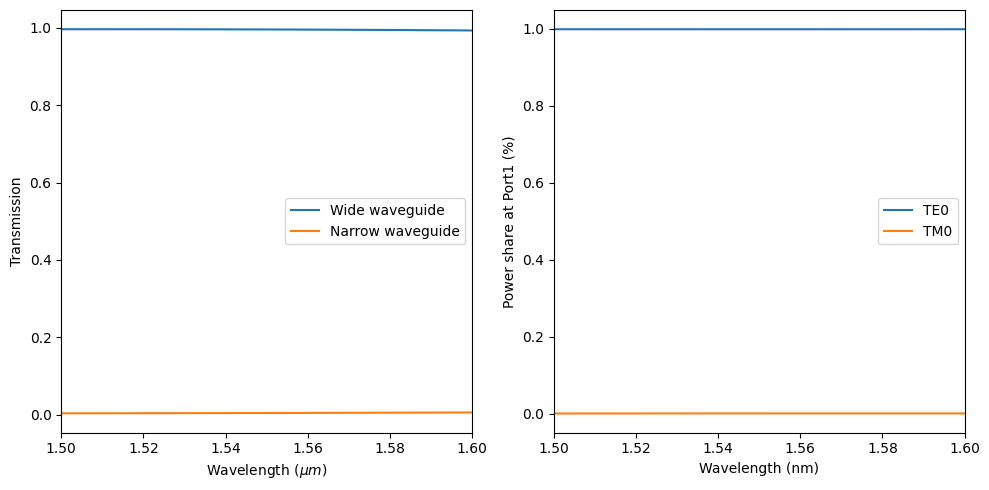

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
T1 = sim_data["flux1"].flux
T2 = sim_data["flux2"].flux

plt.sca(ax1)
plt.plot(ldas, T1, ldas, T2)
plt.xlim(1.5, 1.6)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Transmission")
plt.legend(("Wide waveguide", "Narrow waveguide"))

plt.sca(ax2)
mode_amp = sim_data["mode1"].amps.sel(direction="+")
mode_power = np.abs(mode_amp) ** 2 / T1
plt.plot(ldas, mode_power)
plt.xlim(1.5, 1.6)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Power share at Port1 (%)")
plt.legend(["TE0", "TM0"])


## Case 2: Launching the TM0 Mode at the Input

Next, we investigate the case where the TM0 mode is launched at the input. To set up the simulation, we simply need to copy the previous simulation and update the mode source.

In [12]:
mode_source = td.ModeSource(
    center=(0, -buffer_y / 2, 0),
    size=(2 * w0, 0, 5 * h_co),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
    direction="+",
    mode_spec=mode_spec,
    mode_index=1,
)  # mode_index=1 corresponds to the TM0 mode

sim = sim.copy(update={"sources": [mode_source]})
job = web.Job(simulation=sim, task_name="polarization_splitter_rotator")
sim_data = job.run(path="data/simulation_data.hdf5")


[19:57:18] INFO     Created task 'polarization_splitter_rotator' with task_id                         ]8;id=733279;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=371061;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#120\120]8;;\
                    'd091a335-298e-4a76-87d2-a616abf95ee3'.                                                        

Output()

[19:57:19] INFO     status = queued                                                                   ]8;id=833498;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=687893;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#261\261]8;;\

Output()

[19:57:22] INFO     Maximum FlexUnit cost: 0.692                                                      ]8;id=335118;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=60137;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#252\252]8;;\

[19:57:25] INFO     status = preprocess                                                               ]8;id=618943;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=289069;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#273\273]8;;\

[19:57:31] INFO     starting up solver                                                                ]8;id=512712;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=414620;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#277\277]8;;\

[19:57:41] INFO     running solver                                                                    ]8;id=427733;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=322939;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#283\283]8;;\

Output()

[19:58:11] INFO     early shutoff detected, exiting.                                                  ]8;id=333536;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=738778;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#294\294]8;;\

           INFO     status = postprocess                                                              ]8;id=988248;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=382849;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#300\300]8;;\

Output()

[19:58:27] INFO     status = success                                                                  ]8;id=753577;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=21383;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#306\306]8;;\

           INFO     Billed FlexUnit cost: 0.388                                                       ]8;id=735654;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=804847;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#310\310]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "data/simulation_data.hdf5"        ]8;id=688922;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=529528;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#592\592]8;;\

Output()

[19:58:29] INFO     loading SimulationData from data/simulation_data.hdf5                             ]8;id=630529;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=608039;file://C:\Users\xinzh\Anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#414\414]8;;\

Visualize the field intensity distribution to see the propagation of the input TM0 mode. We can see that the TM0 mode is efficiently converted to the TE1 mode and then coupled to the narrow waveguide through the directional coupler region. 

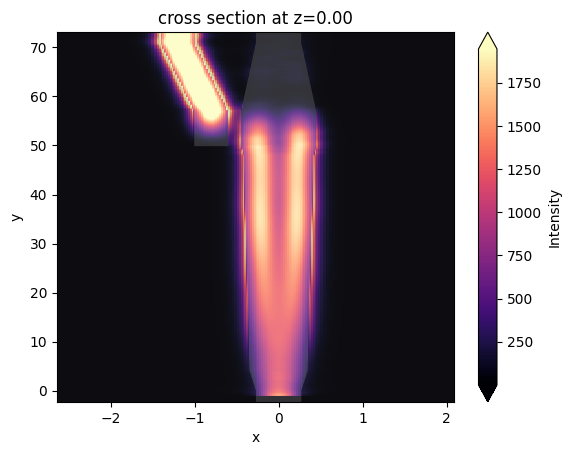

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
sim_data.plot_field("field", "int", ax=ax, f=freq0)
ax.set_aspect("auto")


Plot the transmission at the two outputs. At the central wavelength, above 90% of the power is coupled to the narrow waveguide.

Then plot the mode composition at the narrow waveguide output. We can see that the TE polarization is dominant, indicating a good TM to TE mode conversion efficiency.

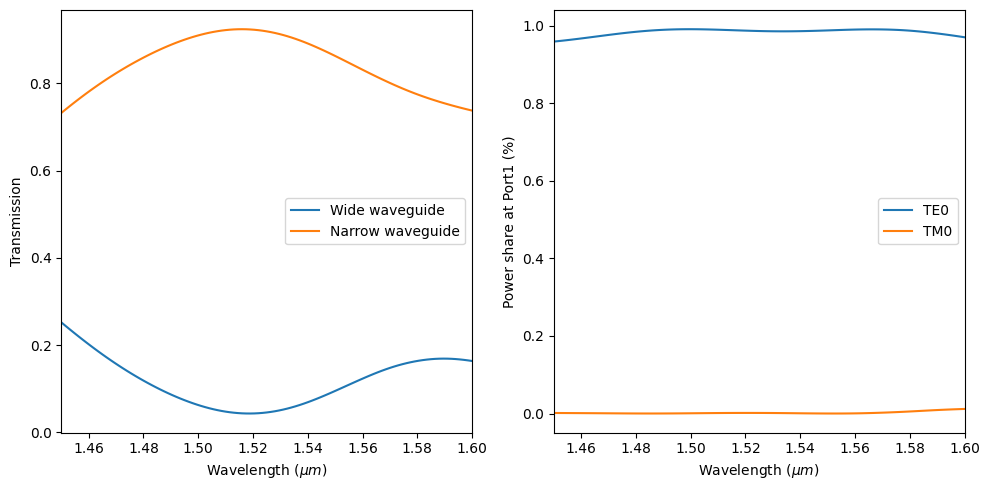

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
T1 = sim_data["flux1"].flux
T2 = sim_data["flux2"].flux

plt.sca(ax1)
plt.plot(ldas, T1, ldas, T2)
plt.xlim(1.45, 1.6)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Transmission")
plt.legend(("Wide waveguide", "Narrow waveguide"))

plt.sca(ax2)
mode_amp = sim_data["mode2"].amps.sel(direction="+")
mode_power = np.abs(mode_amp) ** 2 / T2
plt.plot(ldas, mode_power)
plt.xlim(1.45, 1.6)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Power share at Port1 (%)")
plt.legend(["TE0", "TM0"])


Simulation results from the two cases confirm that we can use this device to separate the TE and TM polarizations as well as convert the TM polarization to TE.